# Examine trans effect of TP53 Hotspot mutation in Colon Cancer

### Specifically examine Phosphorylation of TP53, AURKA, CDK1, XPO1, and STK11

#### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import cptac
import cptac.utils as ut

import seaborn as sns
import matplotlib.pyplot as plt

#Use Colon cancer object
co = cptac.Colon()

### List mutations in first hotspot (cluster including 273 mutation)

In [2]:
hotspot_mutations = ['C135F','C275Y','N239fs*0','P278S','R273C','R273H']

#### Get Proteomic data, append Binary hotspot mutation column

In [3]:
#Use join omics to mutations
proteomics_df = co.join_omics_to_mutations(omics_genes=['TP53','AURKA','CDK1','XPO1','STK11'], omics_df_name='phosphoproteomics', mutations_genes='TP53')

#reduce site multi index, drop database id
proteomics_df = co.reduce_multiindex(proteomics_df, levels_to_drop=['Database_ID'], flatten=True)

#Remove Non-Tumor Samples
proteomics_df = proteomics_df.loc[proteomics_df['Sample_Status'] == 'Tumor']

#Remove columns that are not needed
proteomics_df = proteomics_df.drop(['Sample_Status'],axis=1)
#proteomics_df['TP53_Hotspot_Mutation'] = binary_hotspots

#Show df
proteomics_df.head()

Name,AURKA_phosphoproteomics,CDK1_phosphoproteomics_T161,STK11_phosphoproteomics_S31,TP53_phosphoproteomics_S314,TP53_phosphoproteomics_S315,XPO1_phosphoproteomics_S1055,XPO1_phosphoproteomics_S391,XPO1_phosphoproteomics_S397,TP53_Mutation,TP53_Location,TP53_Mutation_Status
Patient_ID,,,,,,,,,,,
S001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nonsynonymous SNV, nonsynonymous SNV, nonsyno...","[G113S, G113S, G113S, G206S, G206S, G206S, G20...",Multiple_mutation
S002,NaN,-0.774,-0.665,NaN,-1.280,-0.569,NaN,NaN,"[frameshift insertion, frameshift insertion, f...","[E287Wfs*10, E194Wfs*11, E194Wfs*10, E167Wfs*2...",Multiple_mutation
S003,NaN,-0.364,0.177,NaN,-0.996,-0.243,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor
S004,NaN,NaN,0.027,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor
S005,NaN,0.335,-0.332,NaN,NaN,-0.258,NaN,NaN,"[nonsynonymous SNV, nonsynonymous SNV, nonsyno...","[C143Y, C143Y, C116Y, C116Y, C116Y, S260Qfs*29...",Multiple_mutation


In [4]:
for ind, row in proteomics_df.iterrows():
    for mut in row['TP53_Location']:
        if mut in hotspot_mutations:
            proteomics_df.loc[ind, 'TP53_Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'

proteomics_df = proteomics_df.drop(['TP53_Location'],axis=1)
proteomics_df.head()

Name,AURKA_phosphoproteomics,CDK1_phosphoproteomics_T161,STK11_phosphoproteomics_S31,TP53_phosphoproteomics_S314,TP53_phosphoproteomics_S315,XPO1_phosphoproteomics_S1055,XPO1_phosphoproteomics_S391,XPO1_phosphoproteomics_S397,TP53_Mutation,TP53_Mutation_Status,TP53_Hotspot_Mutation
Patient_ID,,,,,,,,,,,
S001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nonsynonymous SNV, nonsynonymous SNV, nonsyno...",Multiple_mutation,NaN
S002,NaN,-0.774,-0.665,NaN,-1.280,-0.569,NaN,NaN,"[frameshift insertion, frameshift insertion, f...",Multiple_mutation,NaN
S003,NaN,-0.364,0.177,NaN,-0.996,-0.243,NaN,NaN,[Wildtype_Tumor],Wildtype_Tumor,NaN
S004,NaN,NaN,0.027,NaN,NaN,NaN,NaN,NaN,[Wildtype_Tumor],Wildtype_Tumor,NaN
S005,NaN,0.335,-0.332,NaN,NaN,-0.258,NaN,NaN,"[nonsynonymous SNV, nonsynonymous SNV, nonsyno...",Multiple_mutation,TP53_Hotspot_Mutation


#### Classify every sample according to TP53 Mutation Status. Use: Wildtype, Hotspot_Missense, Other_Missense, Truncation

Which should take precedence? If there is a hotspot mutation, and is also a truncating mutation in the same sample?

There are 9 samples with a mutation in the hotspot. 4 of these also have truncating mutations, however, leaving only 5 hotspot missense samples.

In [5]:
for ind, row in proteomics_df.iterrows():
    if row['TP53_Mutation_Status'] == 'Wildtype_Tumor':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Wildtype'
    
    if row['TP53_Hotspot_Mutation'] != 'TP53_Hotspot_Mutation':
        if 'nonsynonymous SNV' in row['TP53_Mutation'] or 'nonframeshift deletion' in row['TP53_Mutation'] or 'nonframeshift insertion' in row['TP53_Mutation']:
            proteomics_df.loc[ind, 'TP53_Categorical'] = 'Other_Missense'
            
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Hotspot_Missense'
        
    if 'frameshift insertion' in row['TP53_Mutation'] or 'frameshift deletion' in row['TP53_Mutation'] or 'stopgain' in row['TP53_Mutation']:
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Truncation'
        
        
        
proteomics_df = proteomics_df.drop(['TP53_Mutation', 'TP53_Mutation_Status', 'TP53_Hotspot_Mutation', 'AURKA_phosphoproteomics','TP53_phosphoproteomics_S314','XPO1_phosphoproteomics_S391',], axis = 1)
proteomics_df

Name,CDK1_phosphoproteomics_T161,STK11_phosphoproteomics_S31,TP53_phosphoproteomics_S315,XPO1_phosphoproteomics_S1055,XPO1_phosphoproteomics_S397,TP53_Categorical
Patient_ID,,,,,,
S001,NaN,NaN,NaN,NaN,NaN,Other_Missense
S002,-0.774,-0.665,-1.280,-0.569,NaN,Truncation
S003,-0.364,0.177,-0.996,-0.243,NaN,Wildtype
S004,NaN,0.027,NaN,NaN,NaN,Wildtype
S005,0.335,-0.332,NaN,-0.258,NaN,Truncation
S006,1.116,-0.399,-1.153,NaN,NaN,Hotspot_Missense
S007,0.426,0.112,NaN,0.672,-0.219,Wildtype
S008,NaN,-0.035,NaN,NaN,NaN,Other_Missense
S009,-0.036,0.230,0.088,0.104,-0.258,Wildtype


### Note:

Note that there are 9 samples with a missense mutation in the hotspot, however, 4 of these samples also have a truncating mutation present. These are classified as truncation, not hotspot missense samples.

### Perform t-tests on each protein, comparing Hotspot-Wildtype, Hotspot-Truncation, and Hotspot-Other Missense Mutations

In [6]:
for col in proteomics_df:
    if col != 'TP53_Categorical':
        hotspot_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Hotspot_Missense'][col].dropna()
        truncation_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Truncation'][col].dropna()
        other_missense_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Other_Missense'][col].dropna()
        wt_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Wildtype'][col]
        
        #Hotspot-WT comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, wt_df)
        print("Omics: ", col, "\nComparison: Hotspot vs. Wildtype \nP-Value: ", str(pval))
        
        #Hotspot-Truncation comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, truncation_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Truncation \nP-Value: ", str(pval))
        
        #Hotspot-Other Missense comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, other_missense_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Other Missense \nP-Value: ", str(pval))
        print("\n\n")
        

Omics:  CDK1_phosphoproteomics_T161 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  CDK1_phosphoproteomics_T161 
Comparison: Hotspot vs. Truncation 
P-Value:  0.27613198930077343

Omics:  CDK1_phosphoproteomics_T161 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.30374681853101915



Omics:  STK11_phosphoproteomics_S31 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  STK11_phosphoproteomics_S31 
Comparison: Hotspot vs. Truncation 
P-Value:  0.8880065691522889

Omics:  STK11_phosphoproteomics_S31 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.23225140024997376



Omics:  TP53_phosphoproteomics_S315 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  TP53_phosphoproteomics_S315 
Comparison: Hotspot vs. Truncation 
P-Value:  0.0009791163712264887

Omics:  TP53_phosphoproteomics_S315 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.05331301696329736



Omics:  XPO1_phosphoproteomics_S1055 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  XPO1

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Reformat dataframe for plot

In [7]:
plotdf = pd.melt(proteomics_df, id_vars='TP53_Categorical', var_name='Site', value_name='Phosphorylation')
#plotdf = plotdf.replace({'AURKA_proteomics':'AURKA','XPO1_proteomics':'XPO1','TP53_proteomics':'TP53','CDK1_proteomics':'CDK1','STK11_proteomics':'STK11'})
plotdf = plotdf.replace({'Hotspot_Missense':'Hotspot Missense','Other_Missense':'Other Missense'})
plotdf = plotdf.replace({'CDK1_phosphoproteomics_T161':'CDK1_T161','STK11_phosphoproteomics_S31':'STK11_S31','TP53_phosphoproteomics_S315':'TP53_S315','XPO1_phosphoproteomics_S1055':'XPO1_S1055','XPO1_phosphoproteomics_S397':'XPO1_S397'})


### Make plot illustrating proteomic abundance

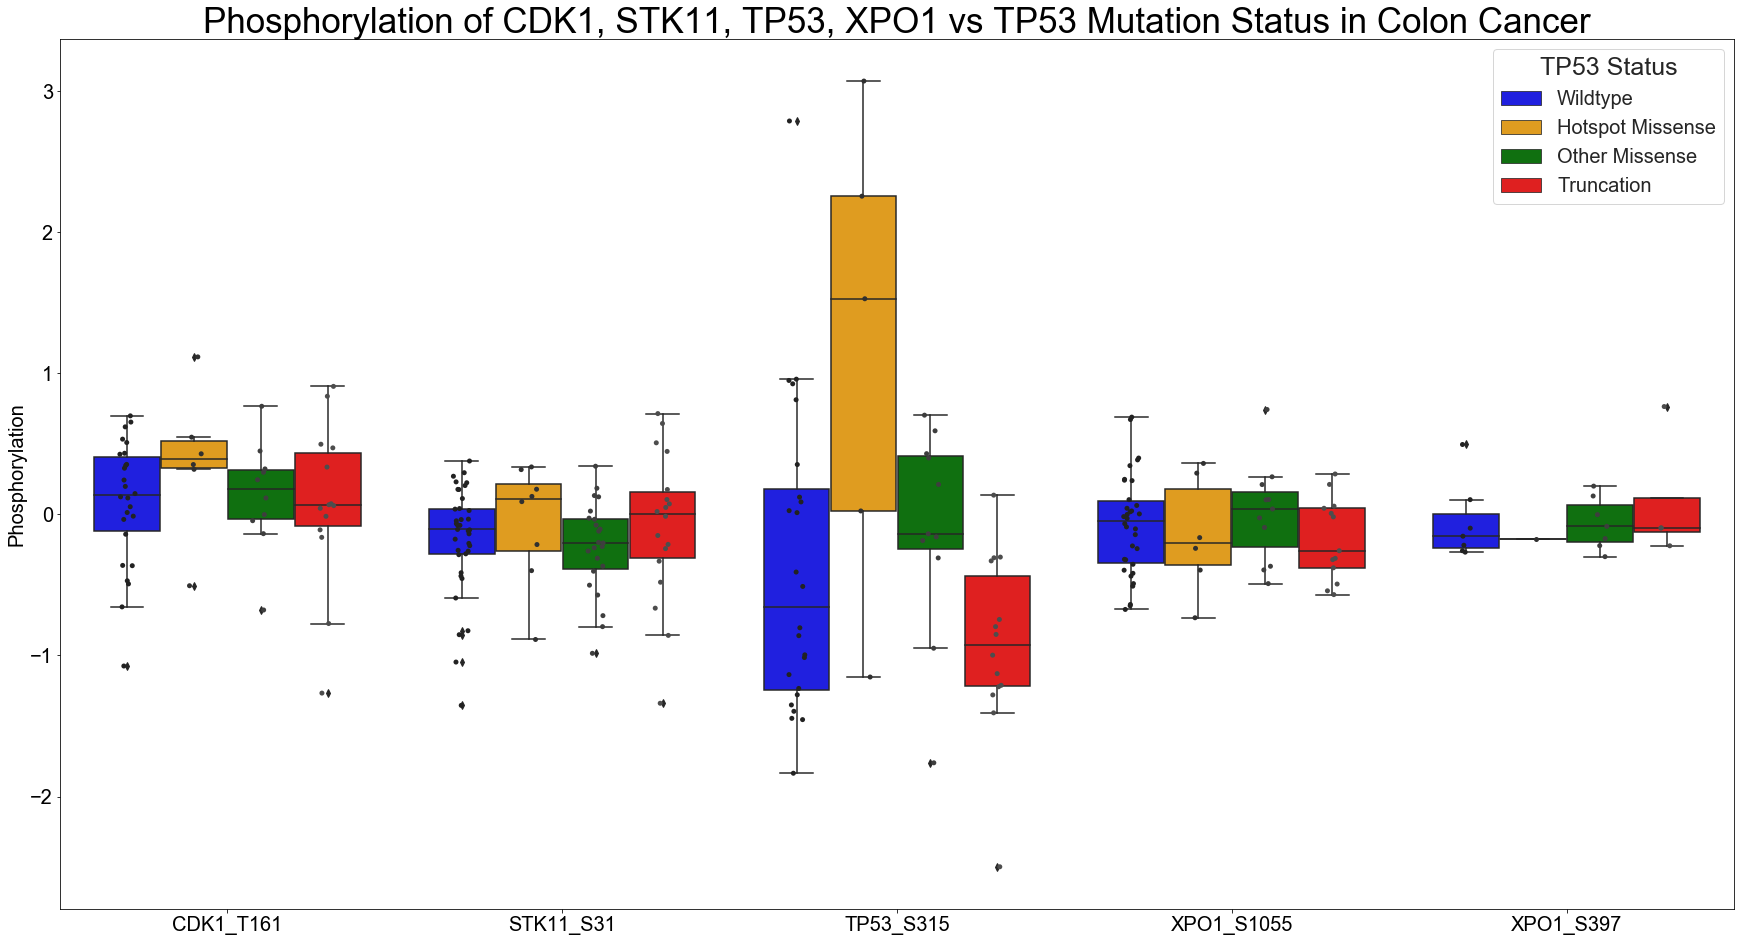

In [8]:
#Set dimensions and Colors
a4_dims = (30, 16)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Wildtype": "blue", "Hotspot Missense": "orange", "Other Missense":"green","Truncation":"red"}

#Make Boxplot
plot = sns.boxplot(data=plotdf, y = 'Phosphorylation', x='Site', hue='TP53_Categorical', palette=my_pal, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'])

#Overlay Striplot
plot = sns.stripplot(data=plotdf, y = 'Phosphorylation', x='Site', hue='TP53_Categorical', color='.3', jitter=True, dodge=True, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'])

#Change Style and label sizes
plot.tick_params(labelsize=20)
plot.set_xlabel('')
plot.set_ylabel('Phosphorylation', fontsize='20')
plot.set_title('Phosphorylation of CDK1, STK11, TP53, XPO1 vs TP53 Mutation Status in Colon Cancer', fontsize = '35')
sns.set_style("white")

#Adjust the Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],['Wildtype','Hotspot Missense','Other Missense','Truncation'], title='TP53 Status', fontsize='20', frameon=True)
plot.get_legend().get_title().set_fontsize('25')